In [ ]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

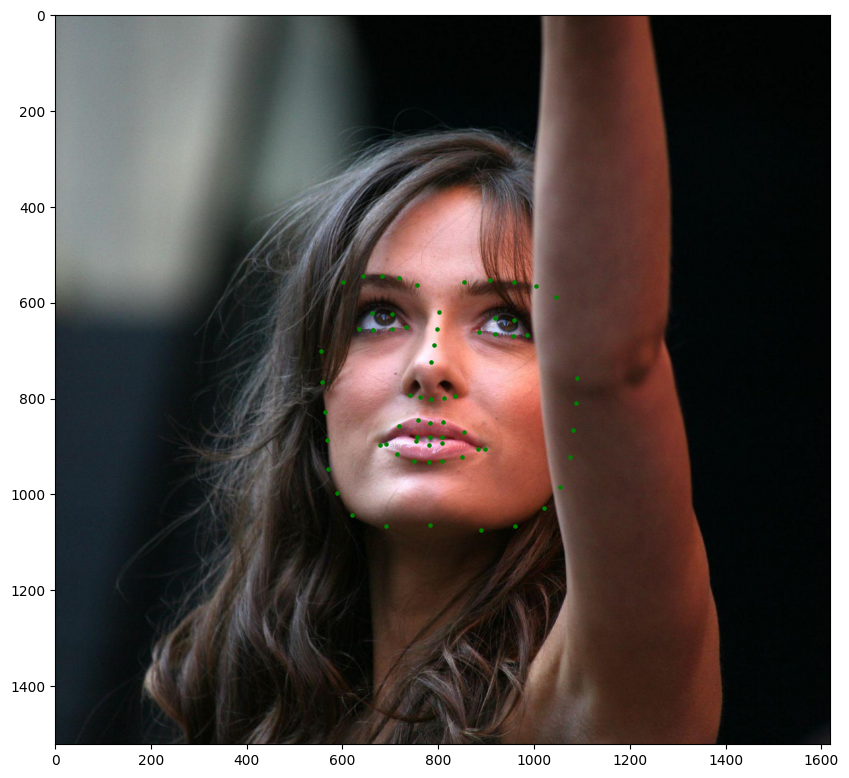

In [ ]:
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

In [ ]:
class Transforms():
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3,
                                              contrast=0.3,
                                              saturation=0.3,
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


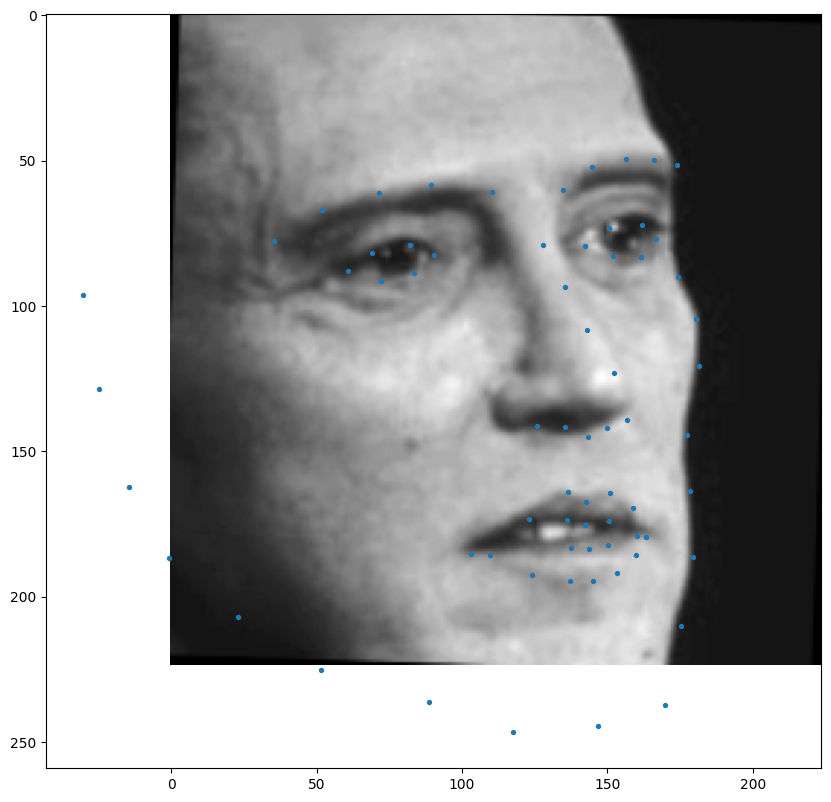

In [ ]:
image, landmarks = dataset[0]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-1849260842.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])


In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

In [ ]:
# ===== FULL WORKING BLOCK: defines dataset, model, train, and predict =====
# Paste this RIGHT AFTER your print_overwrite() function.

import os, time, glob, tarfile, urllib.request, random, math, xml.etree.ElementTree as ET
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import models, transforms

# -----------------------------
# 0) Ensure dataset is present
# -----------------------------
DATA_DIR = 'ibug_300W_large_face_landmark_dataset'
XML_PATH = os.path.join(DATA_DIR, 'labels_ibug_300W_train.xml')

if not os.path.isdir(DATA_DIR) or not os.path.exists(XML_PATH):
    url = 'http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz'
    tgz = 'ibug_300W_large_face_landmark_dataset.tar.gz'
    print('⏬ Downloading dataset (large file; may take a while)...')
    urllib.request.urlretrieve(url, tgz)
    print('📦 Extracting...')
    with tarfile.open(tgz, 'r:gz') as tar:
        tar.extractall('.')
    os.remove(tgz)
    print('✅ Dataset ready.')

# -----------------------------
# 1) Data transforms & dataset
# -----------------------------
class Transforms:
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        # image: PIL.Image (224x224), landmarks in [0,1] coords
        angle = random.uniform(-angle, +angle)

        # rotate image around center (no expand)
        image = image.rotate(angle, resample=Image.BILINEAR)

        # rotate landmarks around center (0.5, 0.5) using numpy
        theta = math.radians(angle)
        R = np.array([[ math.cos(theta), -math.sin(theta)],
                      [ math.sin(theta),  math.cos(theta)]], dtype=np.float32)
        lm = landmarks.astype(np.float32) - 0.5
        lm = lm @ R.T
        lm = lm + 0.5
        return image, lm

    def resize(self, image, landmarks, img_size=(224, 224)):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        cj = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)
        image = cj(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        # crops: dict with strings 'left','top','width','height' from XML
        left = int(float(crops['left']));   top = int(float(crops['top']))
        width = int(float(crops['width'])); height = int(float(crops['height']))

        image = TF.crop(image, top, left, height, width)

        img_np = np.array(image)
        h, w = img_np.shape[:2]
        landmarks = landmarks.astype(np.float32) - np.array([[left, top]], dtype=np.float32)
        landmarks = landmarks / np.array([w, h], dtype=np.float32)
        return image, landmarks

    def __call__(self, image_np, landmarks_xy, crops):
        # image_np is grayscale numpy (H,W), landmarks_xy is (68,2) in absolute pixels
        image = Image.fromarray(image_np)  # to PIL (mode "L")
        image, landmarks = self.crop_face(image, landmarks_xy, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)                  # (1,224,224) float32 [0,1]
        image = TF.normalize(image, [0.5], [0.5])    # normalize to [-1,1]
        return image, landmarks


class FaceLandmarksDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.root_dir = DATA_DIR
        self.image_filenames = []
        self.landmarks = []
        self.crops = []

        tree = ET.parse(XML_PATH)
        root = tree.getroot()

        # Robust XML parsing: iterate over "image" -> first "box" -> 68 "part"
        for img_el in root.iter('image'):
            file_rel = img_el.attrib['file']
            box_el = img_el.find('box')
            if box_el is None:
                continue

            lm = []
            parts = box_el.findall('part')
            # Some XMLs may list parts unordered; sort by "name" if present
            if parts and 'name' in parts[0].attrib:
                parts = sorted(parts, key=lambda p: int(p.attrib['name']))
            for p in parts:
                x = int(float(p.attrib['x']))
                y = int(float(p.attrib['y']))
                lm.append([x, y])

            if len(lm) != 68:
                # Skip rare non-68 landmark entries
                continue

            self.image_filenames.append(os.path.join(self.root_dir, file_rel))
            self.crops.append(box_el.attrib)
            self.landmarks.append(lm)

        self.landmarks = np.array(self.landmarks, dtype=np.float32)
        assert len(self.image_filenames) == len(self.landmarks), "Images and landmarks count mismatch."

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = self.image_filenames[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Could not read image: {img_path}")

        landmarks = self.landmarks[idx]  # absolute pixel coords

        if self.transform:
            img, landmarks = self.transform(img, landmarks, self.crops[idx])

        # shift to [-0.5, 0.5] range for training target
        landmarks = landmarks - 0.5  # still (68,2)
        return img, landmarks


# -----------------------------
# 2) Model
# -----------------------------
class Network(nn.Module):
    def __init__(self, num_classes=136):
        super().__init__()
        self.model = models.resnet18(weights=None)
        # accept 1-channel input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # output 68*2 coordinates
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# -----------------------------
# 3) Data loaders
# -----------------------------
dataset = FaceLandmarksDataset(transform=Transforms())
len_valid = max(1, int(0.1 * len(dataset)))
len_train = len(dataset) - len_valid

g = torch.Generator().manual_seed(42)
train_ds, valid_ds = torch.utils.data.random_split(dataset, [len_train, len_valid], generator=g)

NUM_WORKERS = 0  # safest for Colab/Windows
PIN_MEMORY = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
valid_loader = DataLoader(valid_ds, batch_size=8, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f"✅ Data ready — train batches: {len(train_loader)}, valid batches: {len(valid_loader)}")

# -----------------------------
# 4) Train
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network = Network().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=1e-4)

loss_min = float('inf')
num_epochs = 10
CKPT_PATH = '/content/face_landmarks.pth' if os.path.isdir('/content') else 'face_landmarks.pth'

# Define print_overwrite if it's missing, then rerun your training cell
if 'print_overwrite' not in globals():
    import sys
    def print_overwrite(step, total_step, loss, operation):
        prefix = "Train" if operation == 'train' else "Valid"
        sys.stdout.write(f"\r{prefix} Steps: {step}/{total_step}  Loss: {loss:.4f} ")
        sys.stdout.flush()
        if step == total_step:
            sys.stdout.write("\n")


torch.autograd.set_detect_anomaly(True)
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    # Train
    network.train()
    loss_train = 0.0
    for step, (images, landmarks) in enumerate(train_loader, start=1):
        images = images.to(device, non_blocking=True)
        landmarks = landmarks.view(landmarks.size(0), -1).to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        preds = network(images)
        loss = criterion(preds, landmarks)
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        print_overwrite(step, len(train_loader), loss_train / step, 'train')

    # Valid
    network.eval()
    loss_valid = 0.0
    with torch.no_grad():
        for step, (images, landmarks) in enumerate(valid_loader, start=1):
            images = images.to(device, non_blocking=True)
            landmarks = landmarks.view(landmarks.size(0), -1).to(device, non_blocking=True)
            preds = network(images)
            loss = criterion(preds, landmarks)
            loss_valid += loss.item()
            print_overwrite(step, len(valid_loader), loss_valid / step, 'valid')

    loss_train /= max(1, len(train_loader))
    loss_valid /= max(1, len(valid_loader))
    print('\n' + '-' * 50)
    print(f'Epoch: {epoch}  Train Loss: {loss_train:.4f}  Valid Loss: {loss_valid:.4f}')
    print('-' * 50)

    if loss_valid < loss_min or not os.path.exists(CKPT_PATH):
        loss_min = loss_valid
        torch.save(network.state_dict(), CKPT_PATH)
        print(f"\n✅ New best valid loss {loss_min:.4f} at epoch {epoch}/{num_epochs}")
        print(f"💾 Model saved to {CKPT_PATH}\n")

print('🎉 Training Complete')
print(f"⏱️ Total Elapsed Time : {time.time() - start_time:.2f}s")

# -----------------------------
# 5) Inference & visualization
# -----------------------------
with torch.no_grad():
    if os.path.exists(CKPT_PATH):
        state = torch.load(CKPT_PATH, map_location=device)
        network.load_state_dict(state)
        print(f"🔁 Loaded checkpoint: {CKPT_PATH}")

    network.eval()
    images, landmarks = next(iter(valid_loader))        # images: (B,1,224,224), landmarks: (B,68,2) in [-0.5,0.5]
    images_dev = images.to(device)
    outputs = network(images_dev).detach().cpu()        # (B,136)

    preds = ((outputs + 0.5) * 224).view(-1, 68, 2)     # to pixel coords
    gts = ((landmarks + 0.5) * 224)                     # GT to pixel coords

    n_show = min(8, images.size(0))
    plt.figure(figsize=(10, 5 * n_show))
    for i in range(n_show):
        plt.subplot(n_show, 1, i + 1)
        img = images[i].numpy().squeeze()               # (224,224)
        plt.imshow(img, cmap='gray')
        plt.scatter(preds[i, :, 0], preds[i, :, 1], s=5)
        plt.scatter(gts[i, :, 0],   gts[i, :, 1],   s=5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print('Total number of valid images:', len(valid_ds))


⏬ Downloading dataset (large file; may take a while)...
📦 Extracting...


/tmp/ipython-input-2009068177.py:30: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('.')


✅ Dataset ready.
✅ Data ready — train batches: 93, valid batches: 84
Train Steps: 93/93  Loss: 0.0237 
Valid Steps: 84/84  Loss: 0.0063 

--------------------------------------------------
Epoch: 1  Train Loss: 0.0237  Valid Loss: 0.0063
--------------------------------------------------

✅ New best valid loss 0.0063 at epoch 1/10
💾 Model saved to /content/face_landmarks.pth

Train Steps: 93/93  Loss: 0.0057 
Valid Steps: 84/84  Loss: 0.0056 

--------------------------------------------------
Epoch: 2  Train Loss: 0.0057  Valid Loss: 0.0056
--------------------------------------------------

✅ New best valid loss 0.0056 at epoch 2/10
💾 Model saved to /content/face_landmarks.pth

Train Steps: 93/93  Loss: 0.0051 
Valid Steps: 84/84  Loss: 0.0049 

--------------------------------------------------
Epoch: 3  Train Loss: 0.0051  Valid Loss: 0.0049
--------------------------------------------------

✅ New best valid loss 0.0049 at epoch 3/10
💾 Model saved to /content/face_landmarks.pth

T

Loaded checkpoint: /content/face_landmarks.pth
✅ Saved 32 annotated images to: /content/landmark_outputs


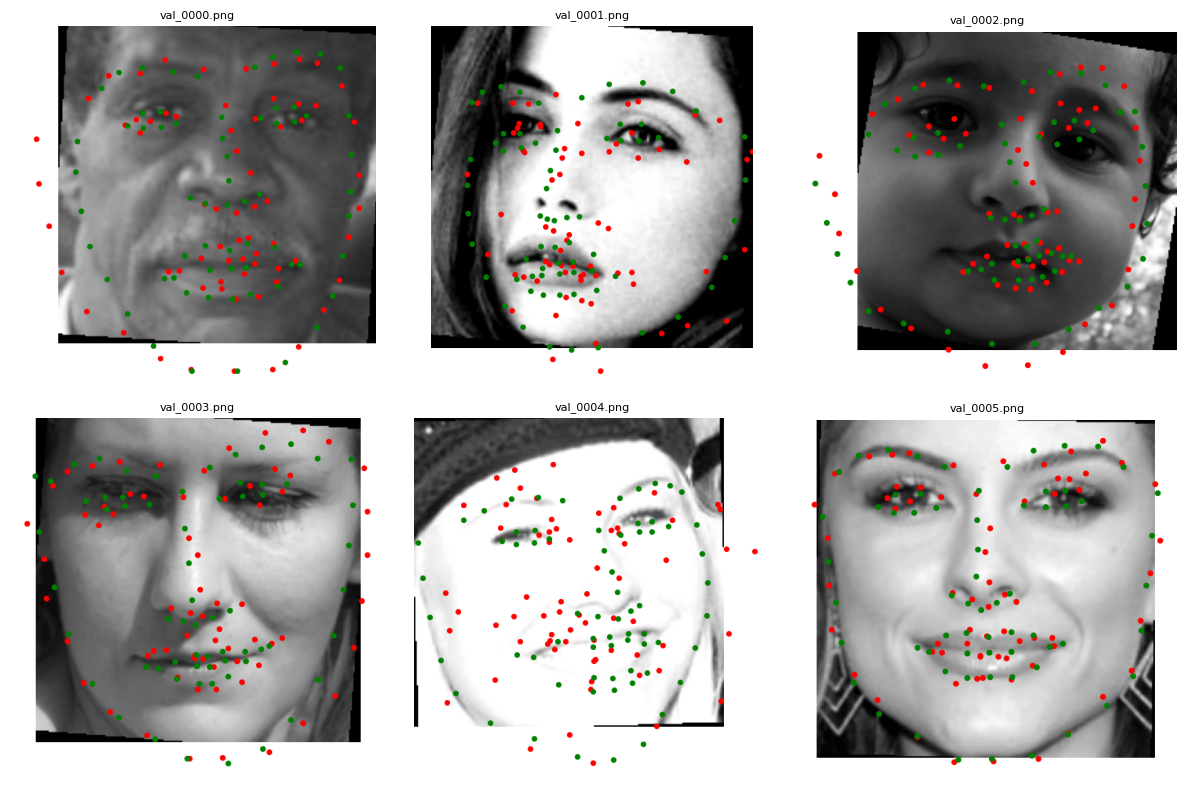

📦 Zipped folder: /content/landmark_outputs.zip


In [ ]:
# === SAVE OUTPUT AS IMAGES (overlaying predicted (•) and GT (•) landmarks) ===
# Paste & run this AFTER training (requires: Network, valid_loader). It will save PNGs.

import os, glob, math, shutil
import numpy as np
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use existing trained model if present; else instantiate & try to load a checkpoint
try:
    model = network.to(device)
except NameError:
    model = Network().to(device)

# Try to load a checkpoint if available
ckpt = None
for p in [
    locals().get('CKPT_PATH', None),
    '/content/face_landmarks.pth',
    './face_landmarks.pth',
    'face_landmarks.pth'
]:
    if p and os.path.exists(p):
        ckpt = p
        break
if ckpt:
    state = torch.load(ckpt, map_location=device)
    model.load_state_dict(state)
    print(f"Loaded checkpoint: {ckpt}")
else:
    print("⚠️ No checkpoint found; using current in-memory model.")

model.eval()

OUT_DIR = '/content/landmark_outputs' if os.path.isdir('/content') else 'landmark_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

N_SAVE = 32   # how many images to export
saved = 0

with torch.no_grad():
    for batch_idx, (images, gt) in enumerate(valid_loader):
        images = images.to(device)
        outputs = model(images).detach().cpu().view(-1, 68, 2)     # (B,68,2) in [-0.5,0.5]
        preds_px = (outputs + 0.5) * 224                            # -> pixels
        gt_px = (gt + 0.5) * 224

        imgs = images.cpu().numpy()                                 # (B,1,224,224)
        for i in range(images.size(0)):
            if saved >= N_SAVE: break

            img = imgs[i].squeeze()
            img = (img * 0.5 + 0.5)  # de-normalize to [0,1]

            fig = plt.figure(figsize=(4,4), dpi=150)
            plt.imshow(img, cmap='gray')
            # Predictions (red) and Ground Truth (green)
            plt.scatter(preds_px[i,:,0], preds_px[i,:,1], s=6, c='r')
            plt.scatter(gt_px[i,:,0],    gt_px[i,:,1],    s=6, c='g')
            plt.axis('off')

            out_path = os.path.join(OUT_DIR, f'val_{saved:04d}.png')
            plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
            plt.close(fig)
            saved += 1

        if saved >= N_SAVE:
            break

print(f"✅ Saved {saved} annotated images to: {OUT_DIR}")

# Optional: quick preview grid of a few saved images inside the notebook
preview_paths = sorted(glob.glob(os.path.join(OUT_DIR, '*.png')))[:6]
if preview_paths:
    cols = 3
    rows = math.ceil(len(preview_paths) / cols)
    plt.figure(figsize=(12, 4*rows))
    for idx, p in enumerate(preview_paths):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(plt.imread(p))
        plt.axis('off')
        plt.title(os.path.basename(p), fontsize=8)
    plt.tight_layout()
    plt.show()

# Optional: zip for download
zip_path = shutil.make_archive(OUT_DIR, 'zip', OUT_DIR)
print(f"📦 Zipped folder: {zip_path}")
